# Stratified Split of Tracks in Music4All

Keunwoo Choi, 2020-12-08

In [765]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter
import skmultilearn  # http://scikit.ml/stratification.html
from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = '../id_csvs/'
LANG_DIR = '../split-language_only'
SPLIT_DIR = '../split-all_labels'
FIG_DIR = '../figures'

font = {'size': 22}

matplotlib.rc('font', **font)

In [767]:
os.makedirs(LANG_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

In [669]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')
            

In [736]:
def analyze_genre_tag_df(df, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[1]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

# Visualize the Occurrence

# `id_genres.csv`

Number of genres: 853


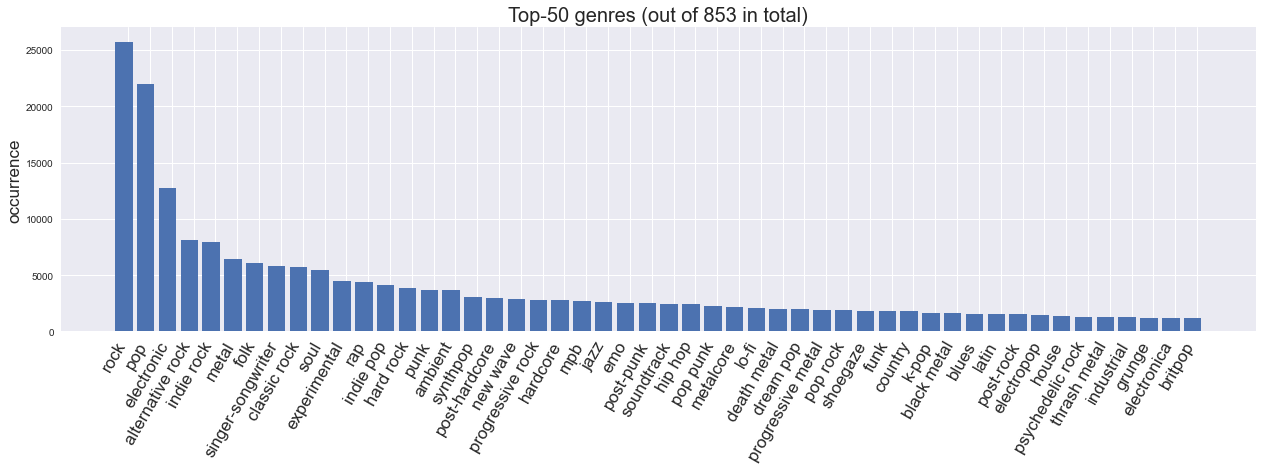

In [744]:
_ = analyze_genre_tag_csv('id_genres.csv', top_n=50)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

# `id_tags.csv`

Number of tags: 19541


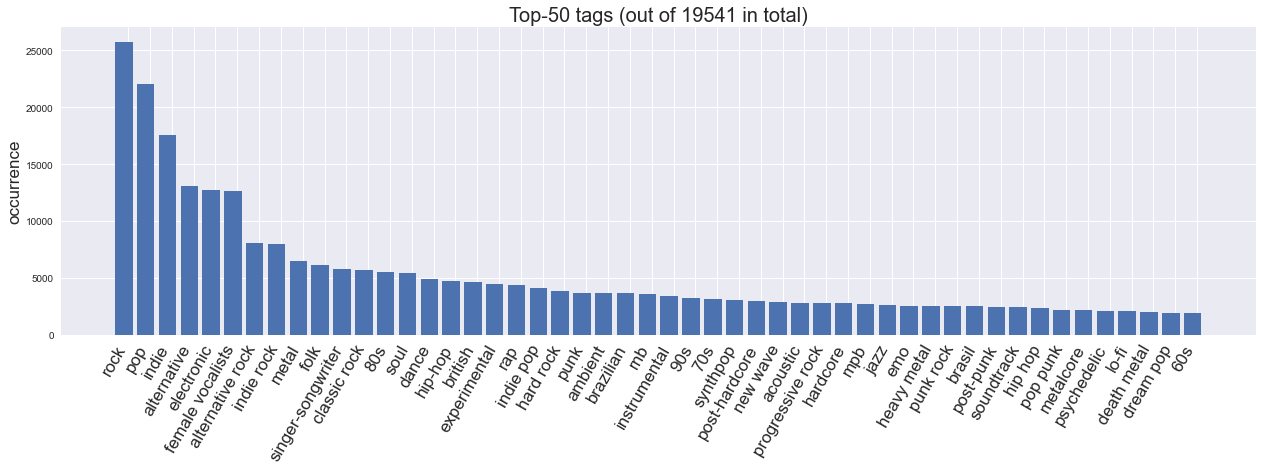

In [745]:
_ = analyze_genre_tag_csv('id_tags.csv', top_n=50)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-tag.png'))

# `id_lang.csv`

Number of lang: 46
Counter({'en': 84103, 'INTRUMENTAL': 9417, 'pt': 7020, 'es': 3225, 'ko': 1145, 'fr': 994, 'ja': 615, 'de': 577, 'pl': 446, 'it': 437, 'sv': 231, 'ru': 187, 'id': 140, 'tr': 125, 'fi': 105, 'no': 99, 'nl': 59, 'tl': 42, 'hr': 41, 'hu': 27, 'sw': 21, 'uk': 20, 'el': 18, 'ca': 18, 'ro': 18, 'da': 17, 'ar': 17, 'et': 16, 'so': 16, 'vi': 13, 'af': 8, 'lt': 7, 'cy': 7, 'sl': 7, 'fa': 6, 'sq': 5, 'th': 4, 'zh-cn': 4, 'pa': 2, 'lv': 2, 'bn': 2, 'cs': 2, 'hi': 1, 'sk': 1, 'bg': 1, 'he': 1})


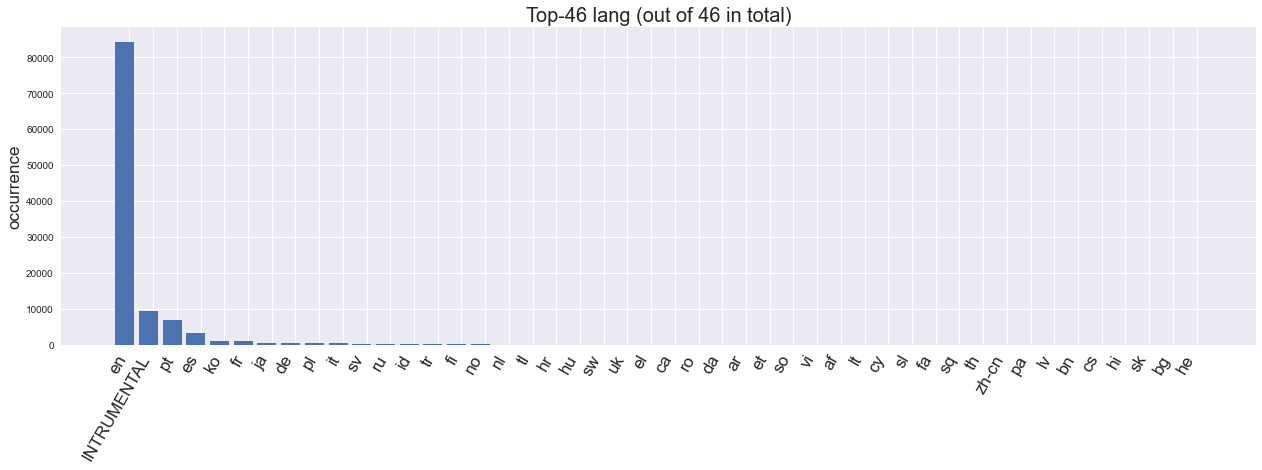

In [746]:
labels_counter = analyze_genre_tag_csv('id_lang.csv', top_n=46)
print(labels_counter)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-language.png'))

Number of lang: 46


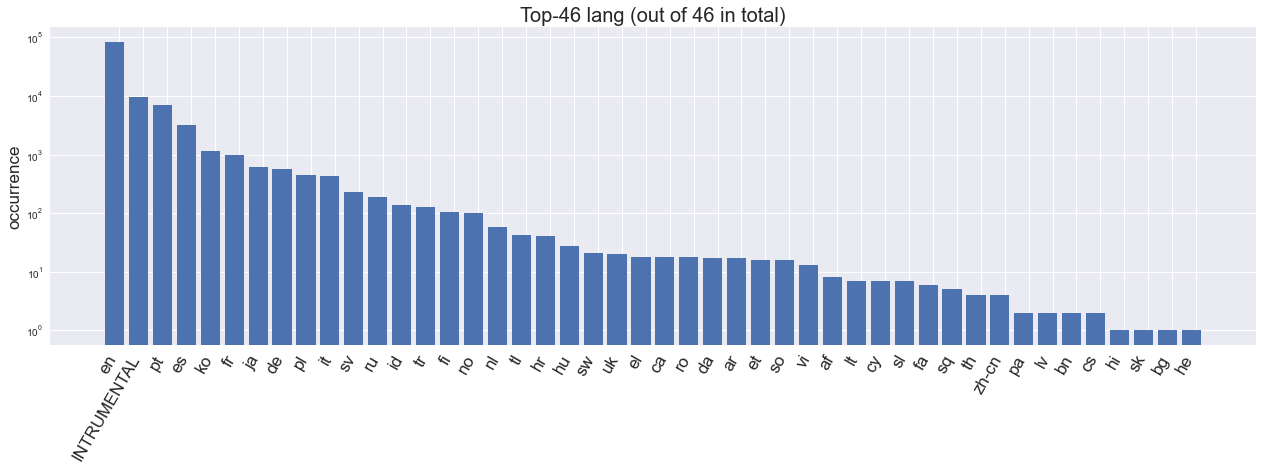

In [747]:
# language in log scale
analyze_genre_tag_csv('id_lang.csv', top_n=46)
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-language-log.png'))

# Split by language - which is single-labeled
## Note that this split have overlapping artist in both sets. See `artist-grouped-stratified-split` for an improved version.

In [626]:
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')

In [627]:
df_lang

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


In [700]:
skf = StratifiedKFold(n_splits=5, random_state=1209)  # 20% for test set
skf.get_n_splits(df_lang['id'], df_lang['lang'])

splits = []

for train_index, test_index in skf.split(df_lang['id'], df_lang['lang']):
    print("TRAIN:", train_index, "TEST:", test_index)
    splits.append({'train': train_index, 'test': test_index})

TRAIN: [  1588   3248   7469 ... 109266 109267 109268] TEST: [    0     1     2 ... 47711 51283 56560]
TRAIN: [     0      1      2 ... 109266 109267 109268] TEST: [ 1588  7469 13225 ... 71489 75306 76446]
TRAIN: [     0      1      2 ... 109266 109267 109268] TEST: [18750 19972 33914 ... 88960 90407 91034]
TRAIN: [     0      1      2 ... 109266 109267 109268] TEST: [ 33645  37330  53933 ...  96375  97711 101448]
TRAIN: [     0      1      2 ...  96375  97711 101448] TEST: [  3248  62098  62515 ... 109266 109267 109268]


/Users/admin/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/Users/admin/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [701]:
primary_language_split = splits[0]

In [702]:
df_lang_train = df_lang.iloc[primary_language_split['train']]
print(len(df_lang_train))
df_lang_test = df_lang.iloc[primary_language_split['test']]
print(len(df_lang_test))

87415
21854


Number of lang: 46


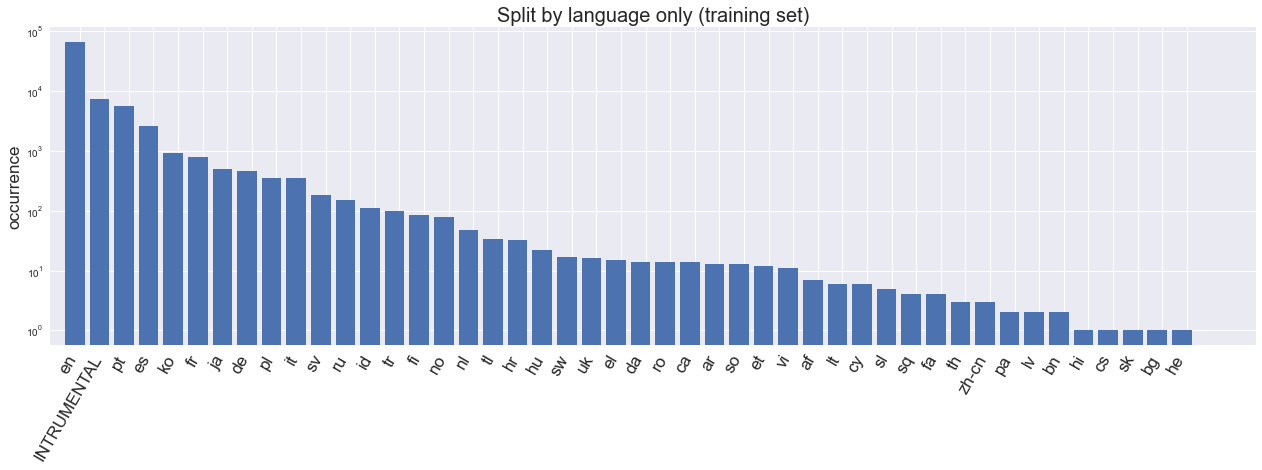

In [758]:
lang_train_counter = analyze_genre_tag_df(df_lang_train, top_n=46)
plt.yscale('log')
plt.xlim([-1, 48])
plt.tight_layout()
plt.title('Split by language only (training set)', size=20)
plt.savefig(os.path.join(FIG_DIR, 'occurrence--split-language_only-training-log.png'))

Number of lang: 39


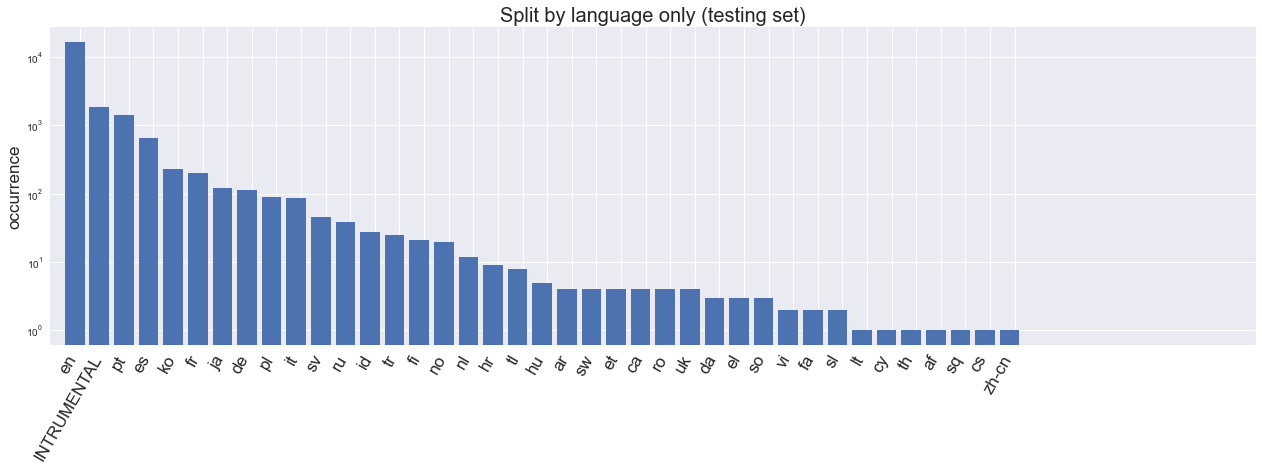

In [757]:
lang_test_counter = analyze_genre_tag_df(df_lang_test)
plt.yscale('log')
plt.xlim([-1, 48])
plt.tight_layout()
plt.title('Split by language only (testing set)', size=20)
plt.savefig(os.path.join(FIG_DIR, 'occurrence--split-language_only-testing-log.png'))

In [705]:
print('Because some language only has 1-2 data points, only these %d languages exist both '
      'in training and test sets (sorted by occurrence count).' %
     len(lang_test_counter))
print((lang_test_counter.keys()))

lang_tags_to_exclude = set(lang_train_counter.keys()).difference(set(lang_test_counter.keys()))
print('In other words, exclude these languages:', lang_tags_to_exclude)

Because some language only has 1-2 data points, only these 39 languages exist both in training and test sets (sorted by occurrence count).
dict_keys(['en', 'INTRUMENTAL', 'pt', 'es', 'ja', 'it', 'ko', 'fr', 'pl', 'da', 'ru', 'lt', 'de', 'ar', 'fi', 'cy', 'sv', 'hr', 'th', 'no', 'sw', 'vi', 'nl', 'id', 'et', 'tr', 'hu', 'tl', 'fa', 'el', 'ca', 'af', 'ro', 'so', 'sl', 'sq', 'uk', 'cs', 'zh-cn'])
In other words, exclude these languages: {'hi', 'lv', 'bn', 'bg', 'sk', 'pa', 'he'}


In [706]:
# Save the outputs
for split in ['train', 'test']:
    write_txt(path=os.path.join(LANG_DIR, split + '.txt'),
             list_of_str=[str(index) for index in primary_language_split[split]])

# Split by every labels (tags, genres, language) -- multi-labeled
## I recommend to use this split by default for any task on `Music4All`

In [707]:
class Splitter:
    def __init__(self, df, test_size=0.2, top_n=1000, random_seed=None):
        if random_seed is not None:
            np.random.seed(random_seed)
        
        self.random_seed = random_seed
            
        column_name = df.columns[1]
        print('column name: %s' % column_name)
        items = df[column_name].tolist()  # list of 'genre1, genre2,..'
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        
        items = Counter(items)
        item_labels = [item[0] for item in items.most_common(top_n)] 
        print('Total number of items considered in the split: %d' % len(item_labels))

        item_to_index = {item: i for (i, item) in enumerate(item_labels)}

        row_inds, col_inds = [], []
        
        # create sparse matrix
        for index, genre_names in zip(df.index, df[column_name]):
            genre_list = genre_names.split(',')
            for genre in genre_list:
                row_inds.append(index)
                col_inds.append(item_to_index[genre])

        self.sparse_labels = csr_matrix((np.ones(len(row_inds)), (row_inds, col_inds)))
        
        # perform splitting
        input_x = df.index
        input_x = input_x.to_numpy().reshape((-1, 1))
        X_train, y_train, X_test, y_test = iterative_train_test_split(input_x, self.sparse_labels, test_size=test_size)
        
        # print the result
        print(pd.DataFrame({
            'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train.A, order=2) for combination in row),
            'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test.A, order=2) for combination in row)
        }).T.fillna(0.0))
        
        self.column_name = column_name
        self.item_labels = item_labels
        self.items = items
        self.item_to_index = item_to_index
        self.split = X_train, y_train, X_test, y_test
        

In [311]:
def add_prefix(label, prefix):
    """Add prefix to a comma-separated labels 
    
    Args:
        label (str): string with comma e.g., 'rock,pop'
        prefix (str)
    """
    labels = label.split(',')
    labels = ['%s_%s' % (prefix, label) for label in labels]
    return ','.join(labels)

def apply_prefix(df, column_name, prefix):
    df[column_name] = df[column_name].map(lambda x: add_prefix(x, prefix=prefix))
    return df

In [315]:
# because some words overlap, let's first add prefix for genre/tag/lang
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_tags = pd.read_csv(os.path.join(CSV_FOLDER, 'id_tags.csv'), header=0, sep='	')
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')

df_genres = apply_prefix(df_genres, 'genres', 'g')
df_tags = apply_prefix(df_tags, 'tags', 't')
df_lang = apply_prefix(df_lang, 'lang', 'l')

In [708]:
# merge three dataframes into one
df_all = pd.concat([df_genres['id'], df_genres['genres'], df_tags['tags'], df_lang['lang']], axis=1)
df_all['all_labels'] = df_all[['genres', 'tags', 'lang']].apply(lambda x: ','.join(x), axis=1)

df_all = df_all.drop(['genres', 'tags', 'lang'], axis=1)
df_all

,id,all_labels
0,0009fFIM1eYThaPg,"g_pop,t_pop,t_british,t_female vocalists,t_dan..."
1,0010xmHR6UICBOYT,"g_underground hip hop,t_instrumental hip-hop,t..."
2,002Jyd0vN4HyCpqL,"g_hard rock,g_rock,g_classic rock,t_hard rock,..."
3,006TYKNjNxWjfKjy,"g_symphonic metal,g_power metal,g_symphonic po..."
4,007LIJOPQ4Sb98qV,"g_post-punk,g_new wave,t_post-punk,t_new wave,..."
...,...,...
109264,zzyyPUs7hC9Nz2e1,"g_hardcore punk,g_punk,g_hardcore,t_hardcore p..."
109265,zzz0n04uuTUA7fNh,"g_pop,t_pop,t_&lt;3,t_omg,en"
109266,zzzj3LYaZtYtbzSr,"g_singer-songwriter,t_female vocalists,t_indie..."
109267,zzznMjZAKnJJXQSj,"g_synthpop,g_remix,g_pop,t_synthpop,t_80s,t_re..."


In [444]:
# it's gonna take some time..
splitter_all = Splitter(df=df_all, top_n=None, random_seed=1209)

column name: all_labels
Total number of items considered in the split: 20440
       (410, 1551)  (410, 8391)  (1059, 1060)  (1059, 8391)  (1059, 1551)  \
train          8.0          1.0          31.0           1.0           1.0   
test           2.0          0.0           8.0           0.0           0.0   

       (410, 1059)  (0, 1060)  (0, 1551)  (0, 410)  (0, 8391)  ...  \
train          1.0       26.0        2.0      34.0        1.0  ...   
test           0.0        6.0        0.0       8.0        0.0  ...   

       (1818, 6749)  (1819, 6749)  (0, 6749)  (548, 993)  (128, 202)  \
train           0.0           0.0        0.0         0.0         0.0   
test            1.0           1.0        1.0         1.0         1.0   

       (129, 176)  (129, 548)  (128, 176)  (129, 202)  (128, 548)  
train         0.0         0.0         0.0         0.0         0.0  
test          1.0         1.0         1.0         1.0         1.0  

[2 rows x 287668 columns]


In [774]:
X_train, y_train, X_test, y_test = splitter_all.split

# Save the outputs
for split_indices, split in zip([X_train, X_test], ['train', 'test']):
    write_txt(path=os.path.join(SPLIT_DIR, split + '.txt'),
             list_of_str=[str(index) for index in split_indices.reshape((-1, ))])

print('Output files (splits) are saved.')

Output files (splits) are saved.


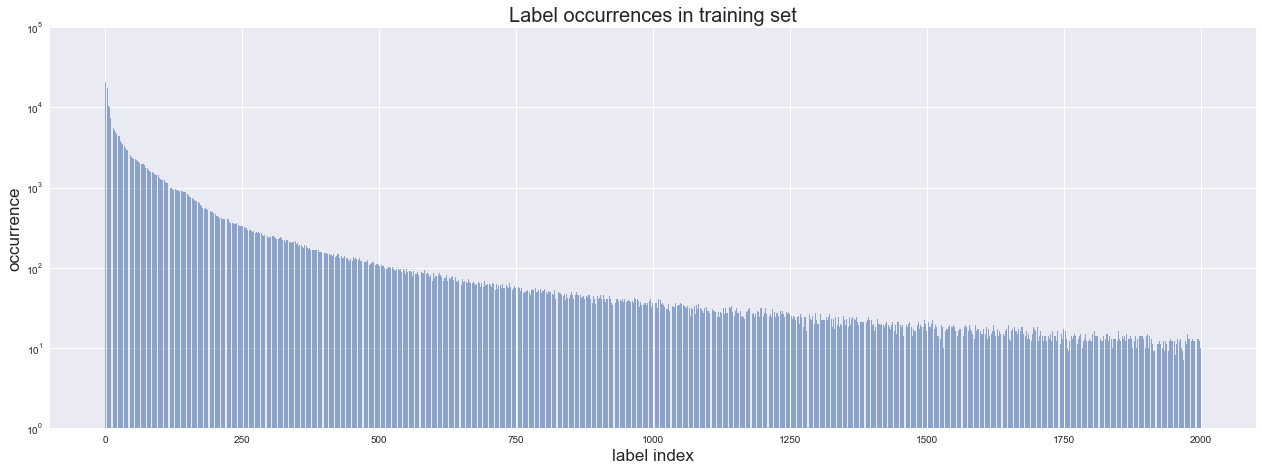

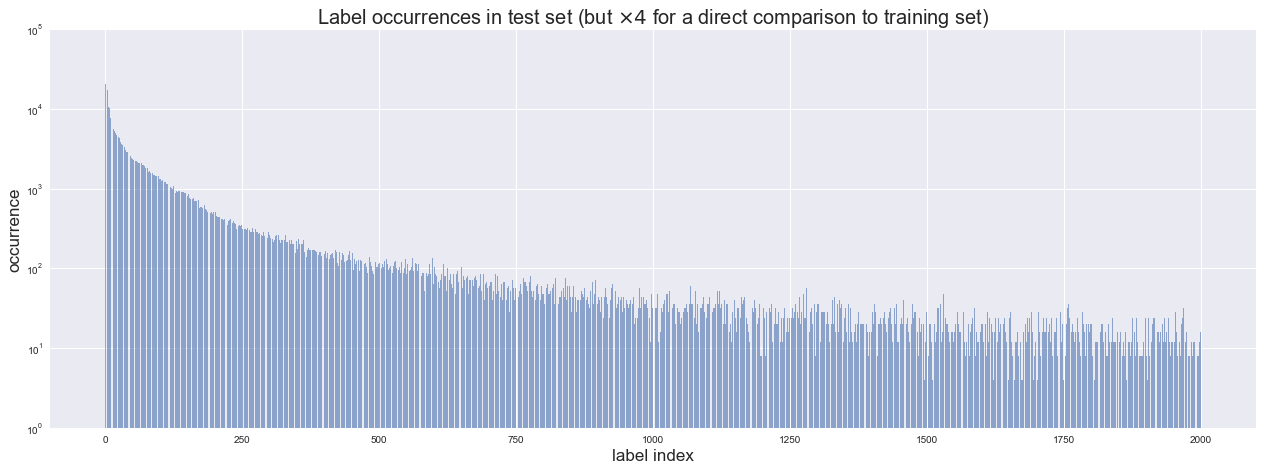

In [764]:
for y, title, split in zip([y_train, 4 * y_test], 
                           ['Label occurrences in training set', 
                            r'Label occurrences in test set (but $\times 4$ for a direct comparison to training set)'],
                           ['training', 'testing']):
    plt.figure(figsize=(18, 7))
    y_plot = np.asarray(y.sum(axis=0)).reshape((-1, ))[:2000]
    plt.bar(np.arange(len(y_plot)), y_plot, alpha=0.6)
    plt.title(title, size=20)
    plt.yscale('log')
    plt.ylim([1, 10 ** 5])
    plt.xlabel('label index', size=17)
    plt.ylabel('occurrence', size=17)
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(FIG_DIR, 'occurrence--split-%s-log.png' % split))


# More analysis

Some labels only occur like x2 or even x1 times. This means we can't just use all the labels in language/tag/genre. 

What would be reasonable `Top-N`'s for each task?

In [775]:
splitter_all.items

Counter({'g_pop': 22013,
         't_pop': 22013,
         't_british': 4622,
         't_female vocalists': 12636,
         't_dance': 4898,
         't_cheryl cole': 18,
         'l_en': 84103,
         'g_underground hip hop': 40,
         't_instrumental hip-hop': 182,
         't_underground hip hop': 40,
         't_instrumental hip hop': 21,
         't_instrumental hiphop': 1,
         'g_hard rock': 3855,
         'g_rock': 25731,
         'g_classic rock': 5688,
         't_hard rock': 3855,
         't_rock': 25731,
         't_classic rock': 5688,
         't_american artist': 271,
         'g_symphonic metal': 1087,
         'g_power metal': 1087,
         'g_symphonic power metal': 67,
         't_symphonic metal': 1087,
         't_power metal': 1087,
         't_symphonic power metal': 67,
         'g_post-punk': 2485,
         'g_new wave': 2859,
         't_post-punk': 2485,
         't_new wave': 2859,
         't_1985': 30,
         'g_indie rock': 7943,
         'g

In [471]:
item_counts = [item[1] for item in splitter_all.items.most_common()]   # counter of occurrence

In [776]:
occurrence_counter = Counter(item_counts)
occurrence_counter  # key -> num_ocurrence, value -> how many labels occur `num_occurrence` times

Counter({84103: 1,
         25731: 2,
         22013: 2,
         17539: 1,
         13114: 1,
         12769: 2,
         12636: 1,
         9417: 1,
         8103: 2,
         7943: 2,
         7020: 1,
         6459: 2,
         6106: 2,
         5793: 2,
         5688: 2,
         5547: 1,
         5458: 2,
         4898: 1,
         4763: 1,
         4622: 1,
         4489: 2,
         4414: 2,
         4141: 2,
         3855: 2,
         3652: 2,
         3645: 2,
         3644: 1,
         3600: 1,
         3394: 1,
         3225: 1,
         3219: 1,
         3130: 1,
         3034: 2,
         2938: 2,
         2859: 2,
         2812: 1,
         2802: 2,
         2790: 2,
         2700: 2,
         2641: 2,
         2537: 2,
         2535: 1,
         2520: 1,
         2501: 1,
         2485: 2,
         2473: 2,
         2408: 2,
         2223: 2,
         2210: 2,
         2070: 1,
         2064: 2,
         2030: 2,
         1963: 2,
         1945: 3,
         1898: 2,
   

In [787]:
print('The most common label is `En` (English) in language label, which occurred %d times' % occurrence_counter[84103])
print('\nAlso,')
for i in np.arange(5, 0, -1):
    print('  - There are %5d labels that only occured %d times' % (occurrence_counter[i], i))


The most common label is `En` (English) in language label, which occurred 1 times

Also,
  - There are   477 labels that only occured 5 times
  - There are   716 labels that only occured 4 times
  - There are  1134 labels that only occured 3 times
  - There are  2423 labels that only occured 2 times
  - There are 12049 labels that only occured 1 times


In [602]:
def count_valid_labels_of_each_task(item_labels, n_label_total):
    valid_labels = item_labels[:n_label_total]
    print('Within %d labels:' % n_label_total)
    print('  - How many language labels are there?')
    print('    %d'  % len([l for l in valid_labels if l.startswith('l_')]))
    
    print('  - How many tag labels are there?')
    print('    %d'  % len([l for l in valid_labels if l.startswith('t_')]))

    print('  - How many genre labels are there?')
    print('    %d'  % len([l for l in valid_labels if l.startswith('g_')]))

### Top N: 500

In [794]:
up_to_n_labels = 500
min_occur_tr, min_occur_te = np.min(y_train[:, :up_to_n_labels].sum(axis=0)), np.min(y_test[:, :up_to_n_labels].sum(axis=0))
print('If we consider the most popular %d labels, minimal occurrence of a label in training/testing set are %d and %d' % (up_to_n_labels, min_occur_tr, min_occur_te))
count_valid_labels_of_each_task(splitter_all.item_labels, up_to_n_labels)

If we consider the most popular 500 labels, minimal occurrence of a label in training/testing set are 102 and 21
Within 500 labels:
  - How many language labels are there?
    13
  - How many tag labels are there?
    321
  - How many genre labels are there?
    166


#### Conclusion: 102 training items and 21 testing items for the scarcest label sounds okay. So top 500 labels seems a good choice as a classification task with a fairly large-size label set

### Top N: 1000

In [790]:
up_to_n_labels = 1000
min_occur_tr, min_occur_te = np.min(y_train[:, :up_to_n_labels].sum(axis=0)), np.min(y_test[:, :up_to_n_labels].sum(axis=0))
print('If we consider the most popular %d labels, minimal occurrence of a label in training/testing set are %d and %d' % (up_to_n_labels, min_occur_tr, min_occur_te))
count_valid_labels_of_each_task(splitter_all.item_labels, up_to_n_labels)

If we consider the most popular 1000 labels, minimal occurrence of a label in training/testing set are 32 and 3
Within 1000 labels:
  - How many language labels are there?
    17
  - How many tag labels are there?
    706
  - How many genre labels are there?
    277


#### Conclusion: Even for the scarcest label, 32 training items and 3 testing items seems too little. We may say 32 training items makes sense for a few shot learning. But testing with 3 items would be noisy, and if the performance is computed with weighting (so that scarce labels and popular labels contribute the same), the noisy testing results of scarce labels would make the overall performance noisy again.

### Top N: 1500

In [791]:
up_to_n_labels = 1500
min_occur_tr, min_occur_te = np.min(y_train[:, :up_to_n_labels].sum(axis=0)), np.min(y_test[:, :up_to_n_labels].sum(axis=0))
print('If we consider the most popular %d labels, minimal occurrence of a label in training/testing set are %d and %d' % (up_to_n_labels, min_occur_tr, min_occur_te))
count_valid_labels_of_each_task(splitter_all.item_labels, up_to_n_labels)

If we consider the most popular 1500 labels, minimal occurrence of a label in training/testing set are 14 and 1
Within 1500 labels:
  - How many language labels are there?
    20
  - How many tag labels are there?
    1132
  - How many genre labels are there?
    348


#### Conclusion: In the test set, there is only one item with the scarcest labels! Their evaluation results would be very noisy. I would not recommend this setup in general.

### Top N: 2000

In [792]:
up_to_n_labels = 2000
min_occur_tr, min_occur_te = np.min(y_train[:, :up_to_n_labels].sum(axis=0)), np.min(y_test[:, :up_to_n_labels].sum(axis=0))
print('If we consider the most popular %d labels, minimal occurrence of a label in training/testing set are %d and %d' % (up_to_n_labels, min_occur_tr, min_occur_te))
count_valid_labels_of_each_task(splitter_all.item_labels, up_to_n_labels)

If we consider the most popular 2000 labels, minimal occurrence of a label in training/testing set are 7 and 0
Within 2000 labels:
  - How many language labels are there?
    29
  - How many tag labels are there?
    1570
  - How many genre labels are there?
    401


#### Conclusion: In the scarcest case, there are only 7 training items and 0 testing items for one label. There might be some interesting use cases with this many + scarce labels.